<a href="https://colab.research.google.com/github/rygonzalez/ML-Colab-Notebooks/blob/main/Dueling_Networks_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dueling Networks

* ECE-GY 6143 Machine Learning - Spring 2020
* Ryan Gonzalez - rag580

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1dmYxxSmN2oYS_GI9MfxYn2WLTbW9JN0m?usp=sharing)

### Abstract

In this notebook we cover the topic of Dueling Networks, an implementation of a Deep Q-Learning (RL) that learns to better assess it's environment and act accordingly. Instead of proposing an entirely new architecture, these networks split the state-action estimator into a value and advantage functions as estimators - making the algorithm more effecient by becoming capable of eliminating actions that are either redundant or inaffectual. We also recreate the linked CoLab Dueling Networks Notebook under different conditions, to experiment with toy models.

---

# Exposition

### Overview of Topic

Machine learning is one of many forms of statistical analysis we now use to perform predictions of events we don't fully understand the relationships for. Unlike Supervised Learning, which teaches a model to make predictions guided by the hand of a labelled dataset, or Unsupervised Learning, which categorizes objects based off their attributes (features), Reinforcement Learning performs analysis through what essentially amounts to trial and error.

In more formal terms, Reinforcement Learning algorithms develop strategies through *exploitation* and *exploration*. These algorithms repeatedly, or recursively, try new approaches to learn the effects of their actions upon the environment, developing criteria for cause-and-effect. This teaches an algorithm to *exploit* their environment, learning how to behave to best achieve their programmed objectives. To avoid missing possible solutions, these algorithms are also trained to periodically *explore* their environments, choosing new or less-ideal responses to the conditions of their environment at random to test for possibly overlooked long-term solutions that may prove more effective.

Constantly checking and testing for optimal states is important, however when one observes a trained Deep RL network in an environment, like an Atari Game, some actions feel erratic, or gittery. This is not a strategy, but rather a product of the network taking redundant actions. The use of Dueling Neural Network architectures seeks to reduce that inefficiency, by using the value and advantage functions as dual estimators to learn to determine course of action and avoid taking unnecessary actions. While this may prove trivial in a game of Pacman, it could be crucial in applications such as robotic gait simulation, or stock price prediction. A Dueling Network's implementation can be thought of a an iteration upon a canvetional Deep Reinforcement or Deep Q network, as it's main distinction is only that of two-stream estimation. This makes the process of integrating a dueling network architecture into an existing network far simpler than developing a new architecture entirely.

---

### Detailed Discussion: Deep Reinforcement Learning

We quickly cover Deep Reinforcement Learning to proved background before covering Dueling Networks, as one provides the foundation for jargon in the other. Skip to the next section if unecessary.

A Reinforcement Learning (RL) uses a sequential decision-making setup to determine the best course of overall action. The algorithm exists in some **state** (S), or current configuration, within an **environment**, some function we most often don't know. It interacts with  the **environment** through an **agent**, which through some **policy** (π) in the decides upon an **action** (A) to move the model from one state to the next.

 The resulting change in state is characterized by a **reward** (r). This reward is typically an integer number measuring the degree of success or failure of an action in a given state, and may be immediate or delayed. Actions performed by the agent are undertaken to maximize reward.

![fig1](https://pathmind.com/images/wiki/simple_RL_schema.png)

*Figure 1:* Block diagram characterizing the cyclical process of Reinforcement Learning.


Through repeated *exploitation and exploration*, an RL algorithm learns which actions lead to the greatest rewards.

Actions are ranked based off their reward and value relative to each other, allowing the algorithm to determine the best course of action. However the reward of every action, present and future, is dependent upon the state of the environment the action is performed in. Hence, the algorithm is really considering **state-action** pairs, which we use to calculate of the **Q-function** or **state-action function**. , we define our Q-function as

$$ Q^\pi(s,a) = \mathbf{E}[R_t | s_t = s, a_t = a, \pi]  ~~~ (1)$$

RL algorithms recursively calculate the Q-function to determine the reward of performing sequential actions, but unlike simple reward considers not only the action but the state it was performed under.

We alos consider the **value** (V) function, which essentially measures the overall return of being in a particular state. The value function is *dependent upon* the Q-function, and is calculated as

$$ V^\pi(s,a) = \mathbf{E}_{a \sim \pi(s)}[Q^\pi(s,a)] ~~~ (2).$$

Because outcome of the value function is dependent upon that of the Q-function, they are effectively coupled.  

We assume we have no original knowledge of the true underlying value function,and that our initial stochastic approximation is poor. We instead treat our current value function as the sum of the *true* value function plus some error, and attempt to solve through recursive methods such that our estimated function matches the true function. In the sense of our Q-function specifically, we may define our function as:

$$
Q^\pi(s,a) = \mathbf{E}_{s'}[r + \gamma \mathbf{E}_{a' \sim \pi(s')}[Q^\pi(s',a')]|s,a,\pi] ~~~ (3).
$$

We also define the optimal Q-function to be $Q^*(s,a) = max_{\pi}Q^\pi(s,a)$, such that under deterministic policy $a = argmax_{a'\in\mathcal{A} }Q^{*}(s,a')$ it follows that $V^*(s) = max_aQ^*(s,a)$. Thus, our optimal Q-function satisfies the **Bellman Equation**:

$$Q^*(s,a) = \mathbf{E}_{s'}[r + \gamma \max_{a'}Q^*(s',a')|s,a]$$

Finally, we define our **advantage** (A) function to be

$$ A^{\pi}(s,a) = Q^{\pi}(s,a) - V^{\pi}(s) ~~~ (4).$$

where $\mathbf{E}_{a \sim \pi(s)}[A^{\pi}(s,a)]=0$. This function relates our coupled state-action and value functions to create a single estimator for an RL algorithm. By comparing the state-action/Q-function, or the reward for performing a given action in a given state, with the value function, an overall rating of how 'good' it is to be in said state, we are capable of ranking ever possible action against each other in a given state.

Deep Neural networks are capable of approximating higher-dimensional functions through statistical methods, meaning that *even in an unknown environment* through a Deep Q-Network (DQN) we can effectively determine the optimal policy function to map state-action pairs to Q-values and achieve desireable results, regardless of whether the state and action spaces too large to be known.

---


### Detailed Discussion: Dueling Networks

Dueling Networks are an attempt to further and improve the implementation of Deep Reinforcement Learning networks, rather than replace them. While conventional one-stream RL networks use the Q-function as it's sole estimator, a Dueling Network decouples it's component the Value and Advantage functions to use as *separate estimators*, creating a two-stream model capable of ignoring redundant or unecessary actions that have no effect upon the environment.

![fig2](https://miro.medium.com/max/1376/1*UVdDMKNCAhRfkIGmEMJqwQ.png)

*Figure 2:* Visual representation of a single-stream RL network (top) and a two-stream Dueling Network (bottom).

Using the definition of Advantage from equation 4, we might attempt to construct our aggregated model as

$$
Q(s,a;\theta,\alpha,\beta) = V(s;\theta,\beta) + A(s,a;\theta,\alpha) ~~~ (5),
$$

however, this is only a parameterized version of the Q-function. It is impossible to recover $V$ and $A$ uniquely, that is, the mapping from $V$ and $A$ to $Q$ is not unique. $Wang et. al.$ address this issue by setting $A$ to zero, yielding

$$
Q(s,a;\theta,\alpha,\beta) = V(s;\theta,\beta) + \big(A(s,a;\theta,\alpha)-\max_{a'\in|\mathcal{A}|} A(s,a';\theta,\alpha)\big) ~~~ (6).
$$

While this makes our solution for $V$ and $A$ unique, it does so at the cost of optimization stability. As such, they propse that the max operator be replaced with the average:

$$
Q(s,a;\theta,\alpha,\beta) = V(s;\theta,\beta) + \big(A(s,a;\theta,\alpha) - \frac{1}{|\mathcal{A}|}\sum_{a'}A(s,a';\theta,\alpha)\big) ~~~ (7).
$$

___

# Programming

### Replication

Code within the Replication section is based *heavily* off the code provided demonstrating the operation of a Dueling Neural Network on NYU Classes. Found great difficulty finding any sort of notebook dating less than 2-3 years back, normally a trivial amount of time in Math or Engineering but incredibly detrimental considering the shift from Python 2 to 3 and Tensorflow Versions 1 to 2 in that timeframe. Spent a number hours in StackOverflow attempting to patch minor problems that would create a workable environment, but many bugs led to more, and I lacked the experience with Python to understand many of my problems or their solutions.

Instead, I experimented with parameters and models in OpenAI's gym, and spent time attempting to learn to develop another environment. Demonstrate it's effects upon three different models by replicating the Score, Loss, and Epsilon plots for each model side-by-side, but was unsuccessful in my attempts simulate in a non-toy environment, like the  Atari OpenAI environment, in the current framework. However, enjoyed the experience, and will likely attempt to build a system after finals eventually.

### Configurations for Colab

In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install pyvirtualdisplay
    from pyvirtualdisplay import Display

    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.4).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [ ]:
import os
from typing import Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_

### Replay buffer

Please see *01.dqn.ipynb* for detailed description.

In [ ]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

### Dueling Network

This is the meat of the Dueling Network. Obviously from the subsection title, but nonetheless. Common feature layer provides the first set of computations determining weights for the estimator before being processed by both the advantage and value layers, and combined and returned as 'q'. Subtraction by the mean comes from the suggested operator described briefly in equation 7 of the DQN + Dueling Network section above.

In [ ]:
class Network(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(Network, self).__init__()

        # set common feature layer
        self.feature_layer = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
        )

        # set advantage layer
        self.advantage_layer = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim),
        )

        # set value layer
        self.value_layer = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        feature = self.feature_layer(x)

        value = self.value_layer(feature)
        advantage = self.advantage_layer(feature)

        q = value + advantage - advantage.mean(dim=-1, keepdim=True)

        return q

### DQN + DuelingNet Agent (w/o Double-DQN & PER)

Here is a summary of DQNAgent class.

| Method           | Note                                                 |
| ---              | ---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|compute_dqn_loss  | return dqn loss.                                     |
|update_model      | update the model by gradient descent.                |
|target_hard_update| hard update from the local model to the target model.|
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|plot              | plot the training progresses.                        |


Aside from the dueling network architecture, the authors suggest to use Double-DQN and Prioritized Experience Replay as extra components for better performance. However, we don't implement them to simplify the tutorial. Here, DQNAgent is totally same as the one from *01.dqn.ipynb*.

In [ ]:
class DQNAgent:
    """DQN Agent interacting with environment.

    Attribute:
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        epsilon (float): parameter for epsilon greedy policy
        epsilon_decay (float): step size to decrease epsilon
        max_epsilon (float): max value of epsilon
        min_epsilon (float): min value of epsilon
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including
                           state, action, reward, next_state, done
    """

    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
    ):
        """Initialization.

        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            epsilon_decay (float): step size to decrease epsilon
            lr (float): learning rate
            max_epsilon (float): max value of epsilon
            min_epsilon (float): min value of epsilon
            gamma (float): discount factor
        """
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n

        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma

        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())

        # transition to store in memory
        self.transition = list()

        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # epsilon greedy policy
        if self.epsilon > np.random.random():
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.dqn(
                torch.FloatTensor(state).to(self.device)
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy()

        if not self.is_test:
            self.transition = [state, selected_action]

        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _ = self.env.step(action)

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)

        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)

        self.optimizer.zero_grad()
        loss.backward()
        # we clip the gradients to have their norm less than or equal to 10.
        clip_grad_norm_(self.dqn.parameters(), 10.0)
        self.optimizer.step()

        return loss.item()

    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False

        state = self.env.reset()
        update_cnt = 0
        epsilons = []
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state = self.env.reset()
                scores.append(score)
                score = 0

            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1

                # linearly decrease epsilon
                self.epsilon = max(
                    self.min_epsilon, self.epsilon - (
                        self.max_epsilon - self.min_epsilon
                    ) * self.epsilon_decay
                )
                epsilons.append(self.epsilon)

                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses, epsilons)

        self.env.close()

    def test(self) -> None:
        """Test the agent."""
        self.is_test = True

        state = self.env.reset()
        done = False
        score = 0

        while not done:
            self.env.render()
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

        print("score: ", score)
        self.env.close()

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> torch.Tensor:
        """Return dqn loss."""
        device = self.device  # for shortening the following lines
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(next_state).max(
            dim=1, keepdim=True
        )[0].detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(self.device)

        # calculate dqn loss
        loss = F.smooth_l1_loss(curr_q_value, target)

        return loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def _plot(
        self,
        frame_idx: int,
        scores: List[float],
        losses: List[float],
        epsilons: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(133)
        plt.title('epsilons')
        plt.plot(epsilons)
        plt.show()

### Environment

You can see the [code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py) and [configurations](https://github.com/openai/gym/blob/master/gym/envs/__init__.py#L53) of CartPole-v0 from OpenAI's repository.

Played with this a bit, but any major changes in env_id changes cascaded up into the DQN + DuelingNet Agent section above.

In [ ]:
# environment

# env_id = "CartPole-v0"
# env = gym.make(env_id)

env_id1 = "CartPole-v0"
env_id2 = "MountainCar-v0"     # Works well w/ unlimited time
env_id3 = "Acrobot-v1"         # Occasionally hilarious

env1 = gym.make(env_id1).env    # Lets simulation run past 6 seconds.
env2 = gym.make(env_id2)
env3 = gym.make(env_id3)


### Set random seed

In [ ]:
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)

#seeding all three envs
env1.seed(seed)
env2.seed(seed)
env3.seed(seed)

[777]

### Initialize

Testing altered initializations against different types of toy models, under same conditions

In [ ]:
# parameters
num_frames = 20000        # For longer testing period, better performance
memory_size = 1000
batch_size = 32
target_update = 100
epsilon_decay = 1 / 2000  # Rate at which we go to minimum epsilon
min_epsilon = .1         # Minimum epsilon (rate of random guesses)
                          # When doing acrobot, want to test new states often

# train
agent1 = DQNAgent(env1, memory_size, batch_size, target_update, epsilon_decay, min_epsilon = min_epsilon)
agent2 = DQNAgent(env2, memory_size, batch_size, target_update, epsilon_decay, min_epsilon = min_epsilon)
agent3 = DQNAgent(env3, memory_size, batch_size, target_update, epsilon_decay, min_epsilon = min_epsilon)


cpu
cpu
cpu


### Train

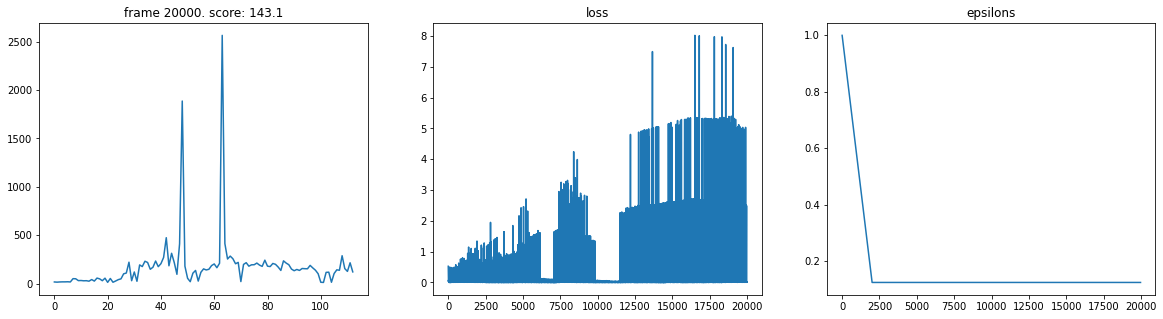

In [ ]:
agent1.train(num_frames)

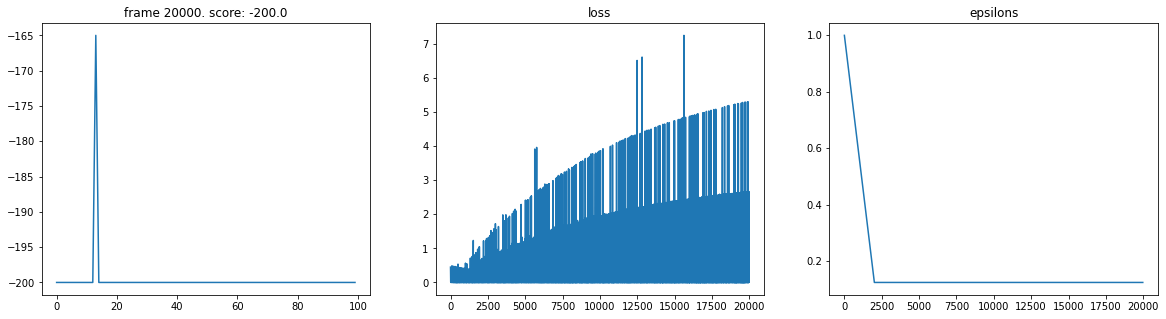

In [ ]:
agent2.train(num_frames)

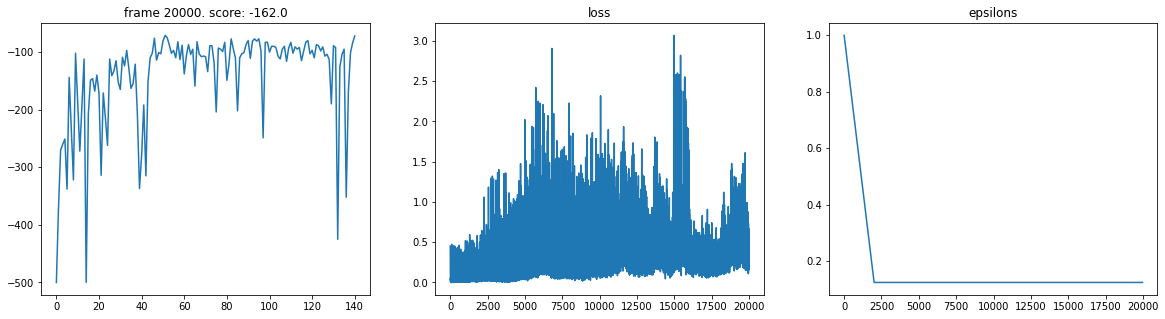

In [ ]:
agent3.train(num_frames)

### Test

Run the trained agent (1 episode).

In [ ]:
agent1.env1 = gym.wrappers.Monitor(env1, "videos", force=True)
agent1.test()

score:  134.0


In [ ]:
agent2.env2 = gym.wrappers.Monitor(env2, "videos", force=True)
agent2.test()

score:  -200.0


In [ ]:
agent3.env3 = gym.wrappers.Monitor(env3, "videos", force=True)
agent3.test()

score:  -103.0


Cart-pole performs well, acrobot seems to perform poorly, but mountain-car seems to fail entirely. Could not determine how to generate videos to demonstrate all three at once.

# Bibliography

### References

[1] Pathmind Wiki's A Beginner's Guide to Deep Reinforcement Learning:
https://pathmind.com/wiki/deep-reinforcement-learning

[2] Simulation and Automated Deep Learning Webinar:
https://www.youtube.com/watch?time_continue=8&v=EHP47tM6ctc&feature=emb_logo

[3] Reinforcement Learning: A Tutorial:
http://www.cs.toronto.edu/~zemel/documents/411/rltutorial.pdf

[4] Deep Q-Network & Dueling network architectures for deep reinforcement learning:
https://www.youtube.com/watch?v=XjsY8-P4WHM





### Ciations

[1] Sutton & Barto:
http://incompleteideas.net/book/bookdraft2017nov5.pdf

[2] Z. Wang et. al.:
https://arxiv.org/pdf/1511.06581.pdf

[3] 0.4 dueling.pynb:
https://colab.research.google.com/github/Curt-Park/rainbow-is-all-you-need/blob/master/04.dueling.ipynb